In [ ]:
#create network inputs with input data and split it by sequence length 
#create network labels with input data and split it by sequence length
#define network
#feed them into the network seq by seq
#network, converts inputs into arrays
# - feeds it into the lstm 
# - output is taken and converted into probabilities
# - loss is calculated
# backprop and gradient and weights and biases are updated
# loop repeats for all the data
# samples are printed at each 100 timestep. 

#--------------------CUDA GPU-------------------------------------#
#-------------------Mini Batch------------------------------------#
#tensor views - share the same underlying mem. .storage().data_ptr()
#first unknown is how to intialize all params as tensors with dtype and cuda? - solved

#to do - weight regularization, setting nn Mod parameters, cross entropy loss, change label shape, running on cuda

In [6]:
import torch
import numpy as np 
import torch.nn as nn
from timeit import default_timer as timer             #from torch import optim

In [7]:
cuda0 = torch.device('cuda:0')

In [8]:
#memory management 

torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(device=0)/1024**3,'gb allocated\n',torch.cuda.max_memory_reserved(device=None)/1024**3,'gb reserved')

0.0 gb allocated
 0.0 gb reserved


In [9]:
data = open(r"C:\Users\vivek\OneDrive\Desktop\AI\warpeace_input.txt", 'r', encoding='utf-8').read()
data = data.replace("\n\n"," ").replace("\n"," ").replace("\'","'")
len(data)

3185156

In [10]:
chars = list(set(data))

char_int = {ch:i for i, ch in enumerate(chars)}
int_char = {i:ch for i, ch in enumerate(chars)}

char_len = len(chars)
seq_len = 10
hs = char_len

In [11]:
class viclstm(nn.Module):
    def __init__(self, vd, hd, sl):
        super().__init__()
        self.vd = vd
        self.hd = hd
        self.sl = sl
        # self.hprev = hprev
        # self.cprev = cprev

        #fgate
        self.fw =  nn.Parameter(torch.randn(hd, hd, requires_grad=True))
        self.fx =  nn.Parameter(torch.randn(vd, hd, requires_grad=True))
        self.fb =  nn.Parameter(torch.randn(hd, requires_grad=True))

        #igate
        self.iw =  nn.Parameter(torch.randn(hd, hd, requires_grad=True))
        self.ix =  nn.Parameter(torch.randn(vd, hd, requires_grad=True))
        self.ib =  nn.Parameter(torch.randn(hd, requires_grad=True))

        #ogate
        self.ow =  nn.Parameter(torch.randn(hd, hd, requires_grad=True))
        self.ox =  nn.Parameter(torch.randn(vd, hd, requires_grad=True))
        self.ob =  nn.Parameter(torch.randn(hd, requires_grad=True))

        #cgate
        self.cw =  nn.Parameter(torch.randn(hd, hd, requires_grad=True))
        self.cx =  nn.Parameter(torch.randn(vd, hd, requires_grad=True))
        self.cb =  nn.Parameter(torch.randn(hd, requires_grad=True))

        #y
        self.yw =  nn.Parameter(torch.randn(hd, vd, requires_grad=True))
        self.yb =  nn.Parameter(torch.randn(vd, requires_grad=True))

        #softmax
        self.sm = nn.Softmax(dim=1)

        #loss
        self.ce = nn.CrossEntropyLoss(reduction='sum')
        #self.ces = nn.CrossEntropyLoss(reduction='sum')

    def train(self, x, l, hprev, cprev):
        f, i, o, c_t, c, h, y = {}, {}, {}, {}, {}, {}, {}
        h[-1] = hprev
        c[-1] = cprev
        loss = 0
        netloss = 0
        for t in np.arange(self.sl):
            f[t] = torch.sigmoid(torch.mm(h[t-1], self.fw) + torch.mm(x[t], self.fx) + self.fb)
            i[t] = torch.sigmoid(torch.mm(h[t-1], self.iw) + torch.mm(x[t], self.ix) + self.ib)
            o[t] = torch.sigmoid(torch.mm(h[t-1], self.ow) + torch.mm( x[t], self.ox) + self.ob)
            c_t[t] = torch.tanh(torch.mm(h[t-1], self.cw) + torch.mm(x[t], self.cx) + self.cb)
            c[t] = f[t]*c[t-1] + i[t]*c_t[t]
            h[t] = self.sm(o[t]*torch.tanh(c[t]))
            #y[t] = self.sm(torch.mm(h[t], self.yw) + self.yb)
            #ny[t] = torch.exp(y[t]) / torch.sum(torch.exp(y[t]))
            with torch.no_grad():
                netloss += float(self.ce(h[t], l[t]))  

        for t in reversed(np.arange(self.sl)):
            loss = self.ce(h[t], l[t])
            loss.backward(retain_graph=True)
            #torch.autograd.grad(loss, x, retain_graph=True)

        #net_params = (self.fw, self.fx, self.fb, self.iw, self.ix, self.ib, self.ow, self.ox, self.ob, self.cw, self.cx, self.cb, self.yw, self.yb)
        #del f, i, o, c_t
        #print(loss) #, "grad \n", self.ow.grad
        return(netloss, h, c[-1], h[-1], o, c_t)
        

In [12]:
model = viclstm(char_len, hs, seq_len)
model.to(cuda0)

viclstm(
  (sm): Softmax(dim=1)
  (ce): CrossEntropyLoss()
)

In [ ]:
#the input cuda time problem, multiply the inputs with zero matrix. ??
batch = 100                 #24 1327 2654

input = np.zeros((batch, seq_len, char_len))
label = np.zeros((batch, seq_len))

cprev = torch.randn(batch, hs, device=cuda0)
hprev = torch.randn(batch, hs, device=cuda0)

In [20]:
opt = torch.optim.AdamW(model.parameters(), lr=0.0090, weight_decay=0.0001)

In [ ]:
def sample(x):
    i = np.random.randint(len(x[0]), size=1)
    j = 0
    s = ''
    while i < len(x[0]):
        while j < len(x) - 1:  #len(x)
            val, index = torch.topk(x[j][i], 1)
            s = s + int_char[index.item()]
            j += 1
        
        i += 1000
        j = 0
        s = s + '\n'
    
    return s

In [ ]:
i = 0
x = 0
y = 0
e = 0

input = np.zeros((batch, seq_len, char_len))
label = np.zeros((batch, seq_len))
s = timer()
while True:                                       #i < len(data): #(len(input)*8000): #800 minibatch
    while x < batch:
        while y < seq_len:
            input[x][y][char_int[data[i]]] = 1
            label[x][y] = char_int[data[i+1]]
            i = i + 1
            y += 1
        x += 1
        y = 0
    
    x = 0
    #print(timer() - s)

    input = np.transpose(input, (1, 0, 2))
    label = np.transpose(label)

    input = torch.as_tensor(input, dtype=torch.float32).to(cuda0)
    input.requires_grad = True
    label = torch.as_tensor(label).type(torch.LongTensor).to(cuda0)


    loss, out, cprev, hprev, ogate, c_tgate = model.train(input, label, hprev, cprev)    
    opt.step()
    opt.zero_grad()

    if i > len(data) - 200:
        print("loss: %f \n sample: \n %s" %(loss, sample(out)))
        print("next iteration", i)

    if e < 35:
        del input, label, out 
        input = np.zeros((batch, seq_len, char_len))
        label = np.zeros((batch, seq_len))

    if i > len(data) - 200:
        i = 0
        e += 1

In [ ]:
loss: 4373.734772 
 sample: 
 nn  tentne

next iteration 3185000
loss: 4373.732635 
 sample: 
 tetet eten

next iteration 3185000

In [ ]:
len(data) - 100

In [ ]:
import torch.onnx as onnx


In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
torch.save(model, 'model.pth')

In [16]:
model.load_state_dict(torch.load('model_weights.pth'))
#model.eval()

<All keys matched successfully>

In [13]:
model = torch.load('model.pth')

In [19]:
for i in model.state_dict(): 
    print(i, "\t", model.state_dict()[i].size())

fw 	 torch.Size([82, 82])
fx 	 torch.Size([82, 82])
fb 	 torch.Size([82])
iw 	 torch.Size([82, 82])
ix 	 torch.Size([82, 82])
ib 	 torch.Size([82])
ow 	 torch.Size([82, 82])
ox 	 torch.Size([82, 82])
ob 	 torch.Size([82])
cw 	 torch.Size([82, 82])
cx 	 torch.Size([82, 82])
cb 	 torch.Size([82])
yw 	 torch.Size([82, 82])
yb 	 torch.Size([82])


In [25]:
for i in opt.state_dict():
    print(i, '\t', opt.state_dict()[i])

state 	 {}
param_groups 	 [{'lr': 0.009, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}]


In [ ]:
temp = [char_int[x] for x in data[0:100]]
temp[0:12]

In [ ]:
input[1][1]

In [ ]:
type(input)

In [ ]:
f1, f2, f3, i1, i2, i3, o1, o2, o3, c1, c2, c3, y1, y2 = model.parameters()

In [ ]:
torch.cuda.memory_summary(device=cuda0, abbreviated=True)

In [ ]:
out[3][0]

In [ ]:
torch.tanh(cprev[1])

In [ ]:
ogate[9][1]

In [ ]:
o1.shape

In [ ]:
o1.grad

In [ ]:
f1

In [ ]:
Parameter containing:
tensor([[-2.3239e+02,  7.0924e+01,  3.9491e-01,  ...,  7.8692e+01,
          5.9998e+00,  1.6348e+00],
        [ 9.5909e+01,  2.1158e+02,  1.1125e+00,  ...,  6.2971e+01,
         -4.7804e+00,  7.7355e-01],
        [ 5.3763e+00, -2.5245e+01,  2.9527e+00,  ...,  4.6807e+00,
          8.0430e-02,  8.4997e+00],
        ...,
        [ 2.8158e+01,  3.8743e+01,  2.4965e+00,  ..., -2.2297e+02,
          2.6968e+00,  4.2567e-01],
        [-3.3122e+01, -5.7431e+01,  2.8925e+00,  ...,  9.9388e+00,
         -5.8481e+00, -1.2157e+00],
        [-7.5390e+00, -2.2621e+01,  5.1694e-01,  ...,  2.7211e+01,
         -5.4672e+00, -3.3846e+00]], device='cuda:0', requires_grad=True)

In [ ]:
o1

In [ ]:
Parameter containing:
tensor([[-5.2531e-01, -1.4635e+02, -6.8992e-02,  ..., -1.4995e+02,
         -4.0778e-01,  3.3888e+00],
        [-7.7124e+00,  1.0975e+02, -3.4822e-01,  ...,  4.0126e+01,
          3.8370e-01,  1.2322e+02],
        [-3.4026e+00, -1.2403e+01, -5.4509e-02,  ..., -2.7597e+00,
         -4.4555e-01, -9.4414e+00],
        ...,
        [-1.6381e+00,  1.2853e+01,  1.1157e-01,  ...,  9.2720e+00,
         -1.0887e+00, -2.9207e+00],
        [ 2.4430e+00, -7.0616e-01, -8.9748e-01,  ..., -1.1848e+01,
          3.7099e-01,  1.1277e+01],
        [ 5.0128e-01,  8.9229e+00, -2.7833e-03,  ...,  1.6569e+00,
          1.2254e+00,  1.9455e+01]], device='cuda:0', requires_grad=True)

In [ ]:
i1

In [ ]:
Parameter containing:
tensor([[ 5.9720e+00,  1.2230e+01, -2.8576e+00,  ..., -2.3407e+00,
         -4.3424e-01, -3.9882e-01],
        [ 1.4828e+01, -4.7199e+00,  1.8905e-01,  ...,  6.4255e-02,
          9.7792e-01,  1.2248e-01],
        [-4.8438e+00,  6.1803e+00, -1.8875e+00,  ...,  1.9264e+00,
         -1.1324e+00, -5.0342e-01],
        ...,
        [-4.8958e+00, -2.2191e+00, -9.9100e-01,  ...,  1.1313e+01,
         -5.8455e-01,  1.0860e-03],
        [ 1.2664e+01,  3.0580e+00, -1.6737e-01,  ...,  9.3617e+00,
          3.1589e-01,  2.5961e-01],
        [ 1.3180e+01,  5.8881e+00,  7.2767e-01,  ...,  4.0381e+00,
          2.0109e-01,  4.9400e-01]], device='cuda:0', requires_grad=True)

In [ ]:
c1

In [ ]:
Parameter containing:
tensor([[ 2.9960e+01, -3.5238e+00,  1.5797e+00,  ..., -2.1352e+01,
          4.5787e-01,  2.1591e-01],
        [-2.1086e+01, -3.9850e+00,  7.9119e-01,  ..., -2.9082e+01,
         -1.3551e-01, -2.0009e-02],
        [ 1.5496e+00, -1.3726e+00,  1.1735e+00,  ...,  1.3972e+01,
          4.4014e-01,  2.4073e-01],
        ...,
        [-1.3704e+01,  1.4505e+00, -1.2554e-01,  ...,  1.9972e+01,
          2.4201e-01,  9.0783e-03],
        [ 1.4450e+01,  2.5837e+00, -1.0337e+00,  ..., -7.6122e+00,
         -1.8296e-01, -1.0495e-01],
        [ 6.1780e+00,  4.3544e+00, -1.6760e+00,  ..., -8.3974e+00,
         -1.6035e-01, -2.2467e-01]], device='cuda:0', requires_grad=True)

In [54]:
model.load_state_dict(torch.load('model_83_1327_weights.pth'))
x = 0
for i in model.state_dict():
    while x < 1:
        a = model.state_dict()[i]
        print(i)
        x += 1


an = a.cpu()
an = an.detach().numpy()

fw


<function matplotlib.pyplot.show(close=None, block=None)>

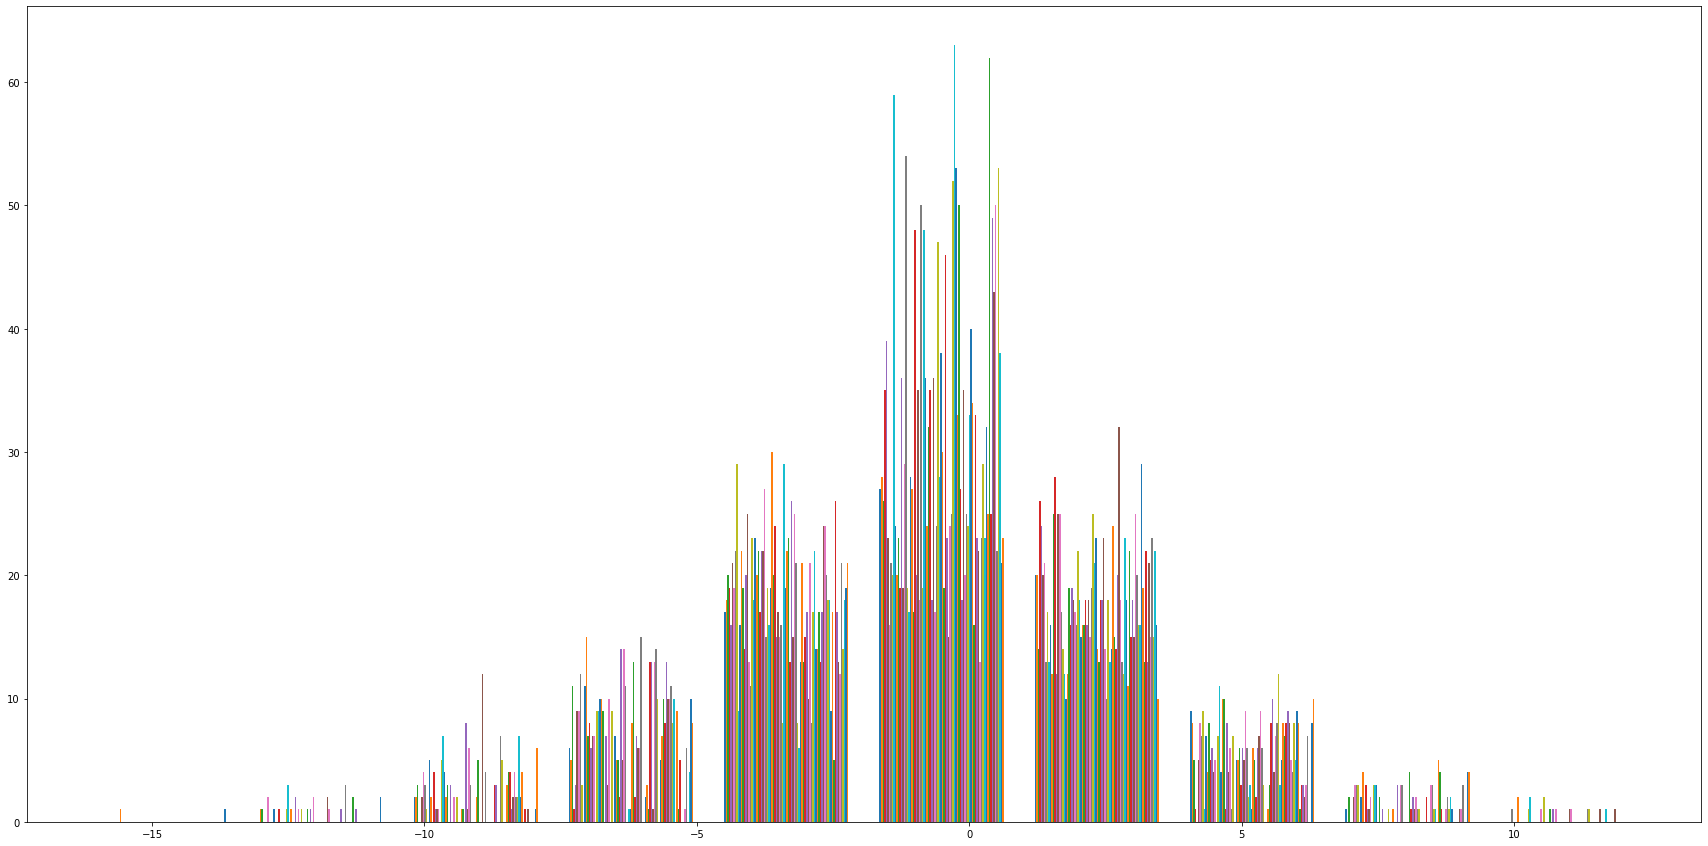

In [57]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30, 15))
ax = plt.subplot()
plt.hist(an)
plt.show